# Interpreting F

In [1]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNOneHotSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import os
os.chdir("../adhunter")

kernel_size = 5
dilation = 3 
hidden = 64
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}

model = ActCNNOneHotSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("adhunter_1he.pt"))
model.eval()

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


ActCNNOneHotSystem(
  (model): ActCNNOneHot(
    (emb): Linear(in_features=20, out_features=64, bias=False)
    (conv_init): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same)
    (res_blocks): ModuleList(
      (0-2): 3 x ResBlock(
        (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_1): ReLU()
        (conv_res): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, dilation=(3,))
        (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_2): ReLU()
        (conv_block): Conv1d(64, 64, kernel_size=(1,), stride=(1,), padding=same)
      )
    )
    (pool): MaxPool1d(kernel_size=40, stride=40, padding=0, dilation=1, ceil_mode=False)
    (lin): Linear(in_features=64, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
  (rmse): MeanSquaredError()
  (pearsonr): PearsonCorrCoef()
  (spearmanr): SpearmanCorrCoef()
)

In [2]:
# CHANGE TO POINT TO PATH ON YOUR COMPUTER!!!!
fn = "data/OrthologTilingDFwActivities_20220131.csv"
# df = pd.read_csv(fn, index_col=0)
# df = df.loc[df.Activity != 0.0]
# # average over duplicates
# df = df.groupby("Seq").mean().reset_index()

df = pd.read_csv(fn)
df = df.loc[df.Activity != 0.0]
df = df.iloc[:, 1:]
df = df.loc[df.loc[:, ['Seq', 'Activity']].drop_duplicates().index]
df = df.sort_values(by=["SpeciesNames", "NativeLocation"]).reset_index(drop=True)

seqs = df.Seq.to_numpy()
# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])


In [3]:
from captum.attr import LayerDeepLift

sns.reset_defaults()

def encode(seq):
    assert len(seq) == 40, "Sequence must be 40 AA!"
    return torch.tensor([[aa_to_i[i] for i in seq]], dtype=torch.int64)

def get_attr(dl, X, baseline, alphabet="ACDEFGHIKLMNPQRSTVWY"):
    attr = dl.attribute(X, baselines=baseline, attribute_to_layer_input=True).detach().numpy()
    attr_df = pd.DataFrame(attr.mean(axis=0)).T
    attr_df.index = list(alphabet)
    return attr_df

def plot_attr(df, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,5))
    sns.heatmap(df, cmap="bwr", center=0, ax=ax)
    ax.set_ylabel("AA")
    ax.set_xlabel("Position")
    ax.set_xticklabels(range(40), ha="center", rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
    if title is not None:
        ax.set_title(title)
    return ax

weak = "EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ"
strong = "ASYNPVVSNNASASEVRGVPAPEDDFDDAMNLWMGLHGPK"

strongAD, weakAD = encode(strong), encode(weak)
sample_input = torch.randint(0, 20, (1, 40), dtype=torch.int64)
baseline_null = torch.zeros(1, 40, dtype=torch.int64) + 21
baseline_gs = encode("".join(["GS" for _ in range(20)]))

# baseline = weakAD
# baseline = torch.zeros_like(sample_input, dtype=torch.int64)
dl = LayerDeepLift(model, layer=model.model.emb, multiply_by_inputs=False,)

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# s = "ABWXXLFLLA"
wlf = df["Seq"].str.contains(r'W..LF')
ff = df["Seq"].str.contains(r'FF')
mfyl = df["Seq"].str.contains(r'MF.Y..L')
print(wlf.sum())
attr_wlf = get_attr(dl, torch.tensor(X[wlf]), weakAD)
attr_ff = get_attr(dl, torch.tensor(X[ff]), weakAD)
attr_mfyl = get_attr(dl, torch.tensor(X[mfyl]), weakAD)

1784


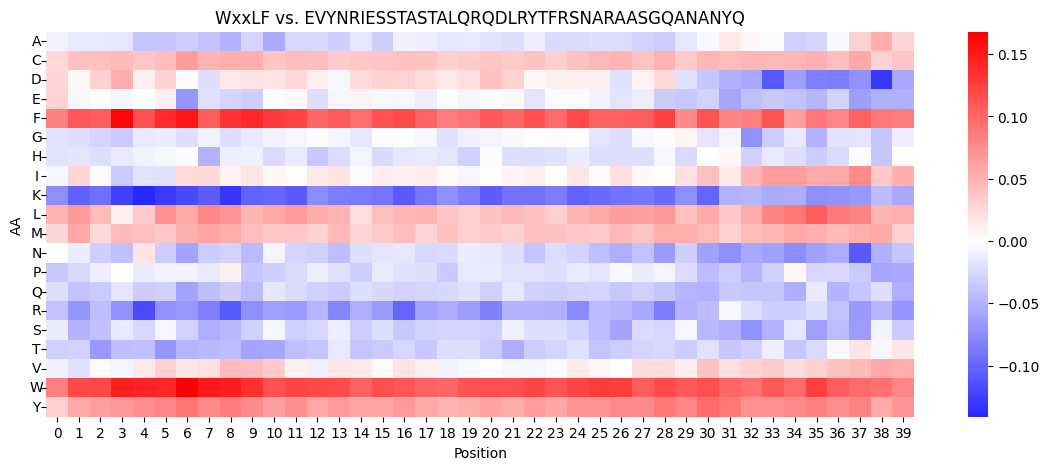

In [5]:
plot_attr(attr_wlf, title=f"WxxLF vs. {weak}")
plt.show()

In [7]:
wlf_scores = dl.attribute(torch.tensor(X[wlf]), baselines=weakAD, attribute_to_layer_input=True).detach().numpy()
print(wlf_scores.shape)


(1784, 40, 20)


## Full-gene importance scores
Since these are tiles over genes, compute 40x20 importance scores for each and generate
1. scatterplots / boxplots
2. Average n x 20 matrices over the whole gene

In [8]:
x_scores = dl.attribute(torch.tensor(X), baselines=weakAD, attribute_to_layer_input=True).detach().numpy()

In [61]:
df0 = df[df["SpeciesNames"] == df["SpeciesNames"].unique()[0]].copy()
df0.head()

SpeciesNames  NativeLocation  \
0  Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri              20   
1  Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri              25   
2  Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri              30   
3  Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri              40   
4  Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri              45   

   NormLocation                                       Seq      Activity  
0          -115  MPTNDLNSAISMFEMNVNTPGAGAAAAAAPCNPSVGAYHM  40288.321578  
1          -110  LNSAISMFEMNVNTPGAGAAAAAAPCNPSVGAYHMGVTPA  83054.688641  
2          -105  SMFEMNVNTPGAGAAAAAAPCNPSVGAYHMGVTPAEQHEA  49277.350646  
3           -95  GAGAAAAAAPCNPSVGAYHMGVTPAEQHEALQSSASTSSS  16941.985045  
4           -90  AAAAPCNPSVGAYHMGVTPAEQHEALQSSASTSSSDSSTL  14317.482226

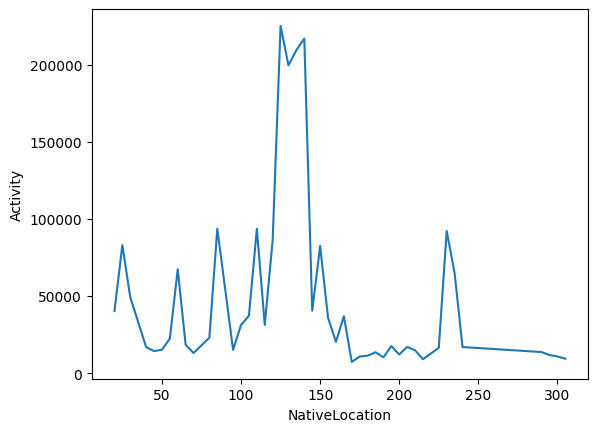

In [62]:
sns.lineplot(df0, x="NativeLocation", y="Activity")
plt.show()

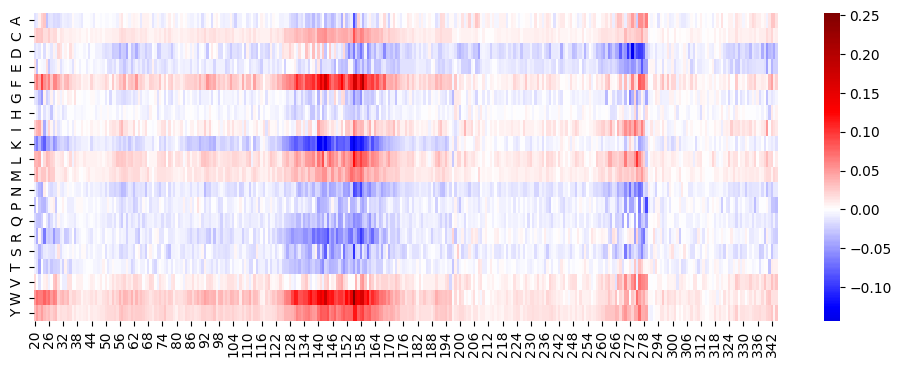

In [63]:
def get_df(df, idx):
    xdf = pd.DataFrame(x_scores[idx]).T
    xdf.columns += df.iloc[idx]["NativeLocation"]
    xdf.index = list(alphabet)
    return xdf
# THIS DOESN'T WORK CORRECTLY!!! 
M = pd.concat([get_df(df0, i) for i in range(len(df0))], axis=1,)
M_bar = M.T.groupby(M.columns).mean().T
M_std = M.T.groupby(M.columns).std().T

fig, ax = plt.subplots(figsize=(12,4))
sns.heatmap(M_bar, center=0, cmap="seismic", ax=ax)
plt.show()

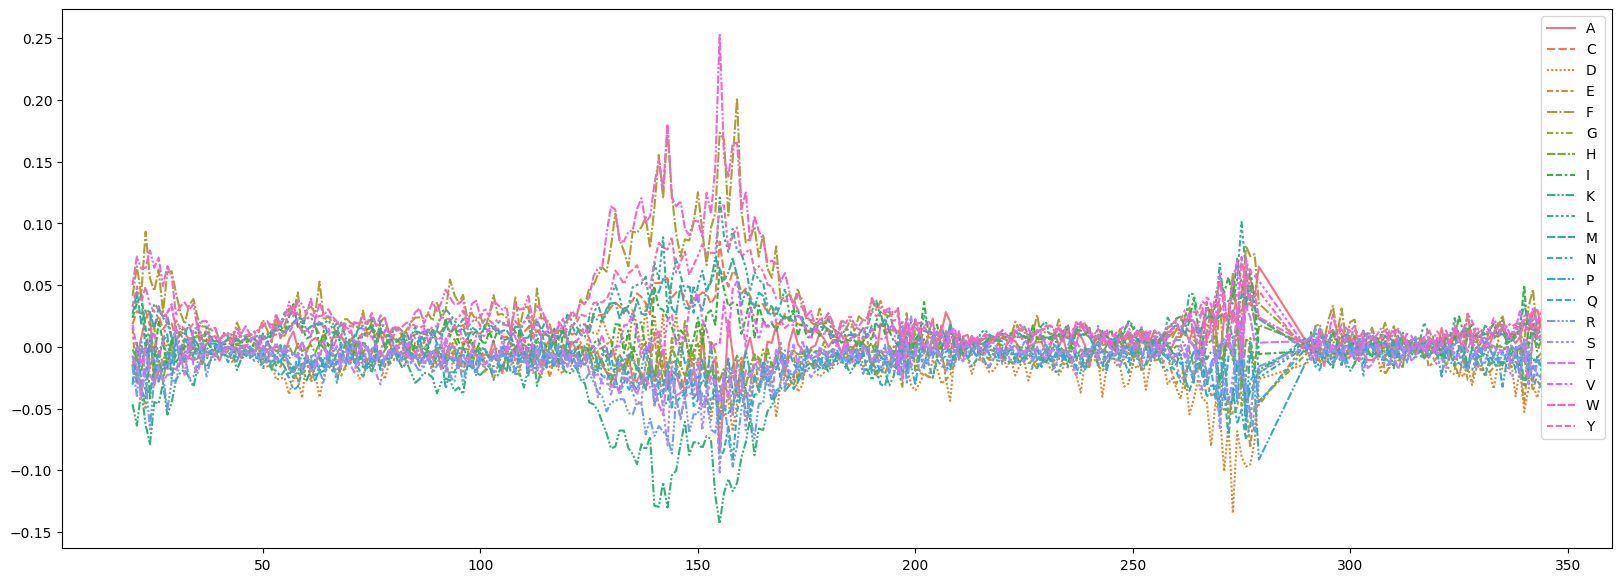

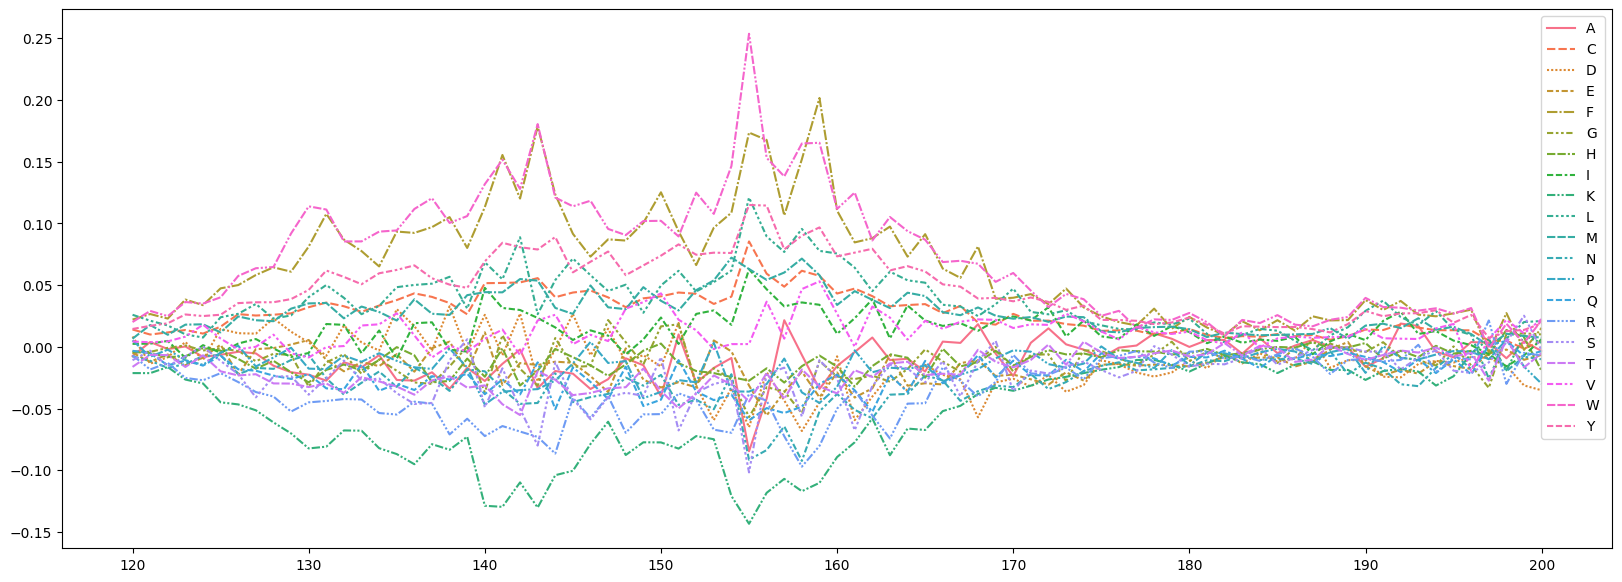

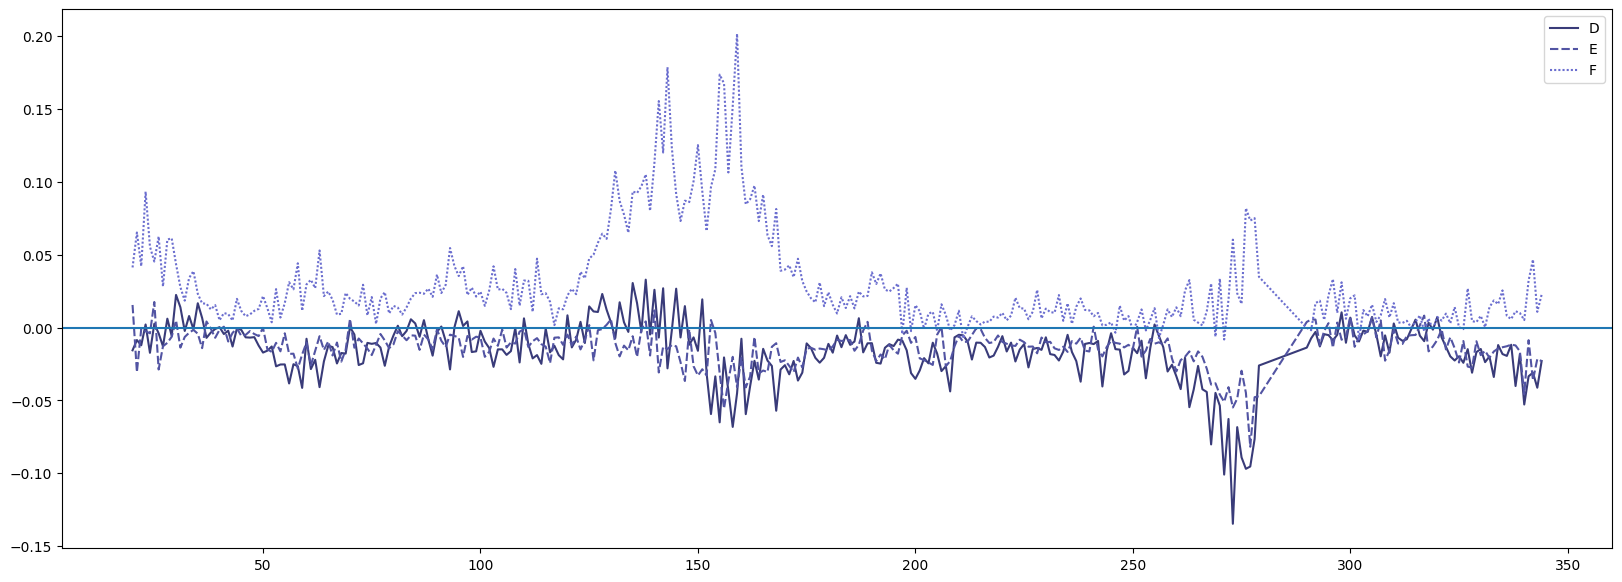

In [68]:
fig, ax = plt.subplots(figsize=(20,7))
sns.lineplot(M_bar.T, ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(20,7))
sns.lineplot(M_bar.T.loc[120:200], ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(20,7))
sns.lineplot(M_bar.loc[["D", "E", "F"]].T, palette="tab20b", ax=ax)
plt.axhline(0)
plt.show()

In [65]:
import logomaker

M_bar

20        21        22        23        24        25        26   \
A -0.014885 -0.010345  0.007366  0.023271  0.028164 -0.031255 -0.015439   
C  0.018432  0.028856  0.027061  0.029122  0.017383  0.016363  0.025319   
D -0.015633 -0.008594 -0.012160  0.002109 -0.017330  0.002544 -0.003955   
E  0.015481 -0.030565 -0.000789 -0.002560 -0.003956  0.017524 -0.028782   
F  0.041231  0.065207  0.042106  0.093235  0.055493  0.045291  0.062426   
G -0.011590 -0.016800 -0.031743 -0.049439  0.007164 -0.022685 -0.013401   
H -0.002160 -0.009528 -0.020335  0.001770 -0.015739 -0.005301 -0.008678   
I  0.023418  0.035439  0.041689  0.015052 -0.041814 -0.011482  0.021110   
K -0.046536 -0.063863 -0.035084 -0.062976 -0.079004 -0.044802 -0.045977   
L  0.035563  0.036484  0.041259 -0.003386  0.018813  0.034879  0.030341   
M  0.026759  0.044313  0.018744  0.030245  0.028066  0.015199  0.031558   
N -0.007067 -0.022269 -0.034842 -0.042399  0.009425 -0.001987 -0.013419   
P -0.030676  0.003328 -0.026979 -0.034761 -0.037319 -0.019878 -0.004667   
Q -0.017976 -0.028024 -0.030791 -0.021297  0.001252 -0.012001 -0.028321   
R -0.015575 -0.039753  0.005475 -0.026363 -0.066636 -0.023868 -0.025627   
S -0.011463 -0.014674 -0.036903 -0.023619 -0.010834 -0.009757 -0.011771   
T -0.007900 -0.015677 -0.042566 -0.000479 -0.023139 -0.029248 -0.016136   
V  0.017958 -0.000862 -0.014174 -0.001701  0.005998  0.011245 -0.007575   
W  0.049982  0.073147  0.063274  0.064104  0.078250  0.064018  0.072301   
Y  0.032284  0.048861  0.036492  0.048692  0.033753  0.028449  0.033089   

        27        28        29   ...       335       336       337       338  \
A -0.011596 -0.017847 -0.017332  ...  0.015554  0.008763  0.008847  0.002823   
C  0.014307  0.018976  0.018918  ...  0.010888  0.005121  0.010120  0.009430   
D -0.012904  0.006078 -0.005743  ... -0.018194 -0.019462 -0.011808 -0.040129   
E -0.012826 -0.010499 -0.006350  ... -0.013527 -0.012839 -0.011742 -0.012284   
F  0.028239  0.060356  0.061250  ...  0.025486  0.007932  0.005811  0.011197   
G  0.008473 -0.014477  0.002075  ... -0.005652  0.006876 -0.016457 -0.006835   
H -0.028753 -0.005765  0.003069  ... -0.000332 -0.002570 -0.001248 -0.007189   
I  0.004159 -0.016753  0.007198  ...  0.015676  0.003000  0.004924  0.010932   
K -0.029562 -0.054880 -0.045055  ... -0.015057 -0.003854 -0.005863 -0.000659   
L  0.023534  0.019426  0.007577  ...  0.021497  0.002194  0.010661  0.012775   
M  0.024672  0.025651  0.007650  ...  0.010077  0.010770  0.004643  0.007579   
N -0.019294 -0.012377 -0.012849  ... -0.012434 -0.011790 -0.005425 -0.018657   
P  0.004544  0.010077 -0.025676  ... -0.032373 -0.011351 -0.000649 -0.000215   
Q -0.016428 -0.004207 -0.013369  ... -0.003804 -0.011258 -0.011017 -0.007134   
R -0.022948 -0.050920 -0.027562  ... -0.008014 -0.006271  0.001097 -0.002806   
S -0.014441 -0.016367 -0.007234  ... -0.006190 -0.005456 -0.024226 -0.021649   
T -0.027878 -0.022563 -0.022393  ... -0.003183  0.000101 -0.013995 -0.002572   
V  0.002321  0.027882  0.034632  ...  0.012177  0.016556  0.006921  0.014368   
W  0.049207  0.065426  0.057109  ...  0.017476  0.007559  0.009626  0.018641   
Y  0.023974  0.027571  0.032710  ...  0.017849  0.016630  0.018947  0.015981   

        339       340       341       342       343       344  
A  0.008204 -0.006382  0.013002  0.027263  0.030050  0.014731  
C  0.009046  0.019127  0.012984  0.019772  0.006554  0.009984  
D -0.018130 -0.052809 -0.033460 -0.030958 -0.041296 -0.022981  
E -0.016332 -0.045735 -0.008692 -0.036126 -0.021590 -0.023037  
F  0.009948  0.005119  0.032228  0.046650  0.010796  0.022646  
G  0.001059 -0.030470 -0.006948 -0.011637 -0.008870 -0.004723  
H  0.001152 -0.009386 -0.025766  0.011150 -0.003741  0.005838  
I  0.013273  0.049978 -0.000356  0.019491  0.013894  0.010296  
K -0.015983 -0.001293 -0.005821 -0.011205 -0.008103 -0.016096  
L  0.019647  0.034284  0.018978  0.021594  0.000139  0.009858  
M  0.013259  0.018647  0.018583  0.006813  0.02

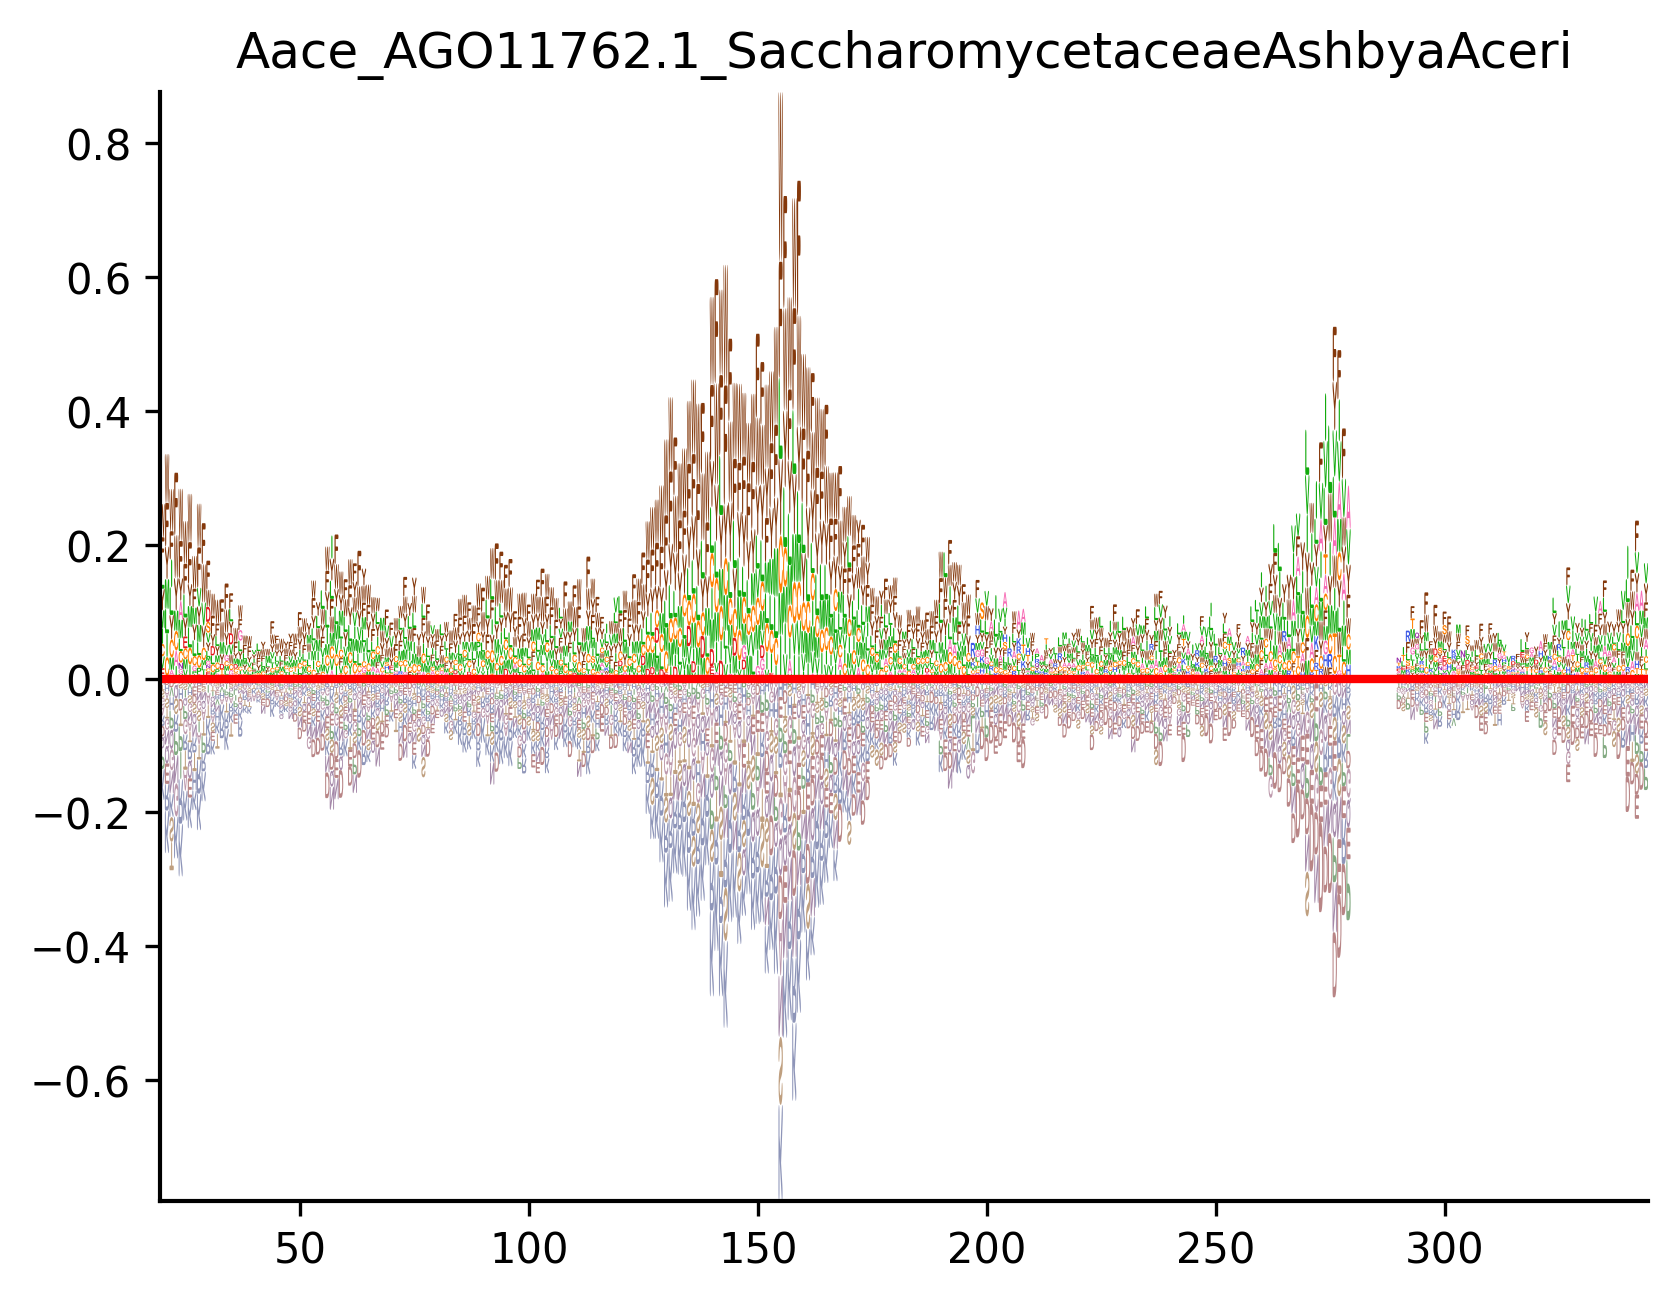

In [66]:
fig, ax = plt.subplots(dpi=300)
crp_logo = logomaker.Logo(M_bar.T,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                          color_scheme="dmslogo_funcgroup",
                          ax=ax)
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.ax.axhline(0, c='r', linewidth=2)
crp_logo.ax.set_title(df0["SpeciesNames"].unique().item())
plt.show()

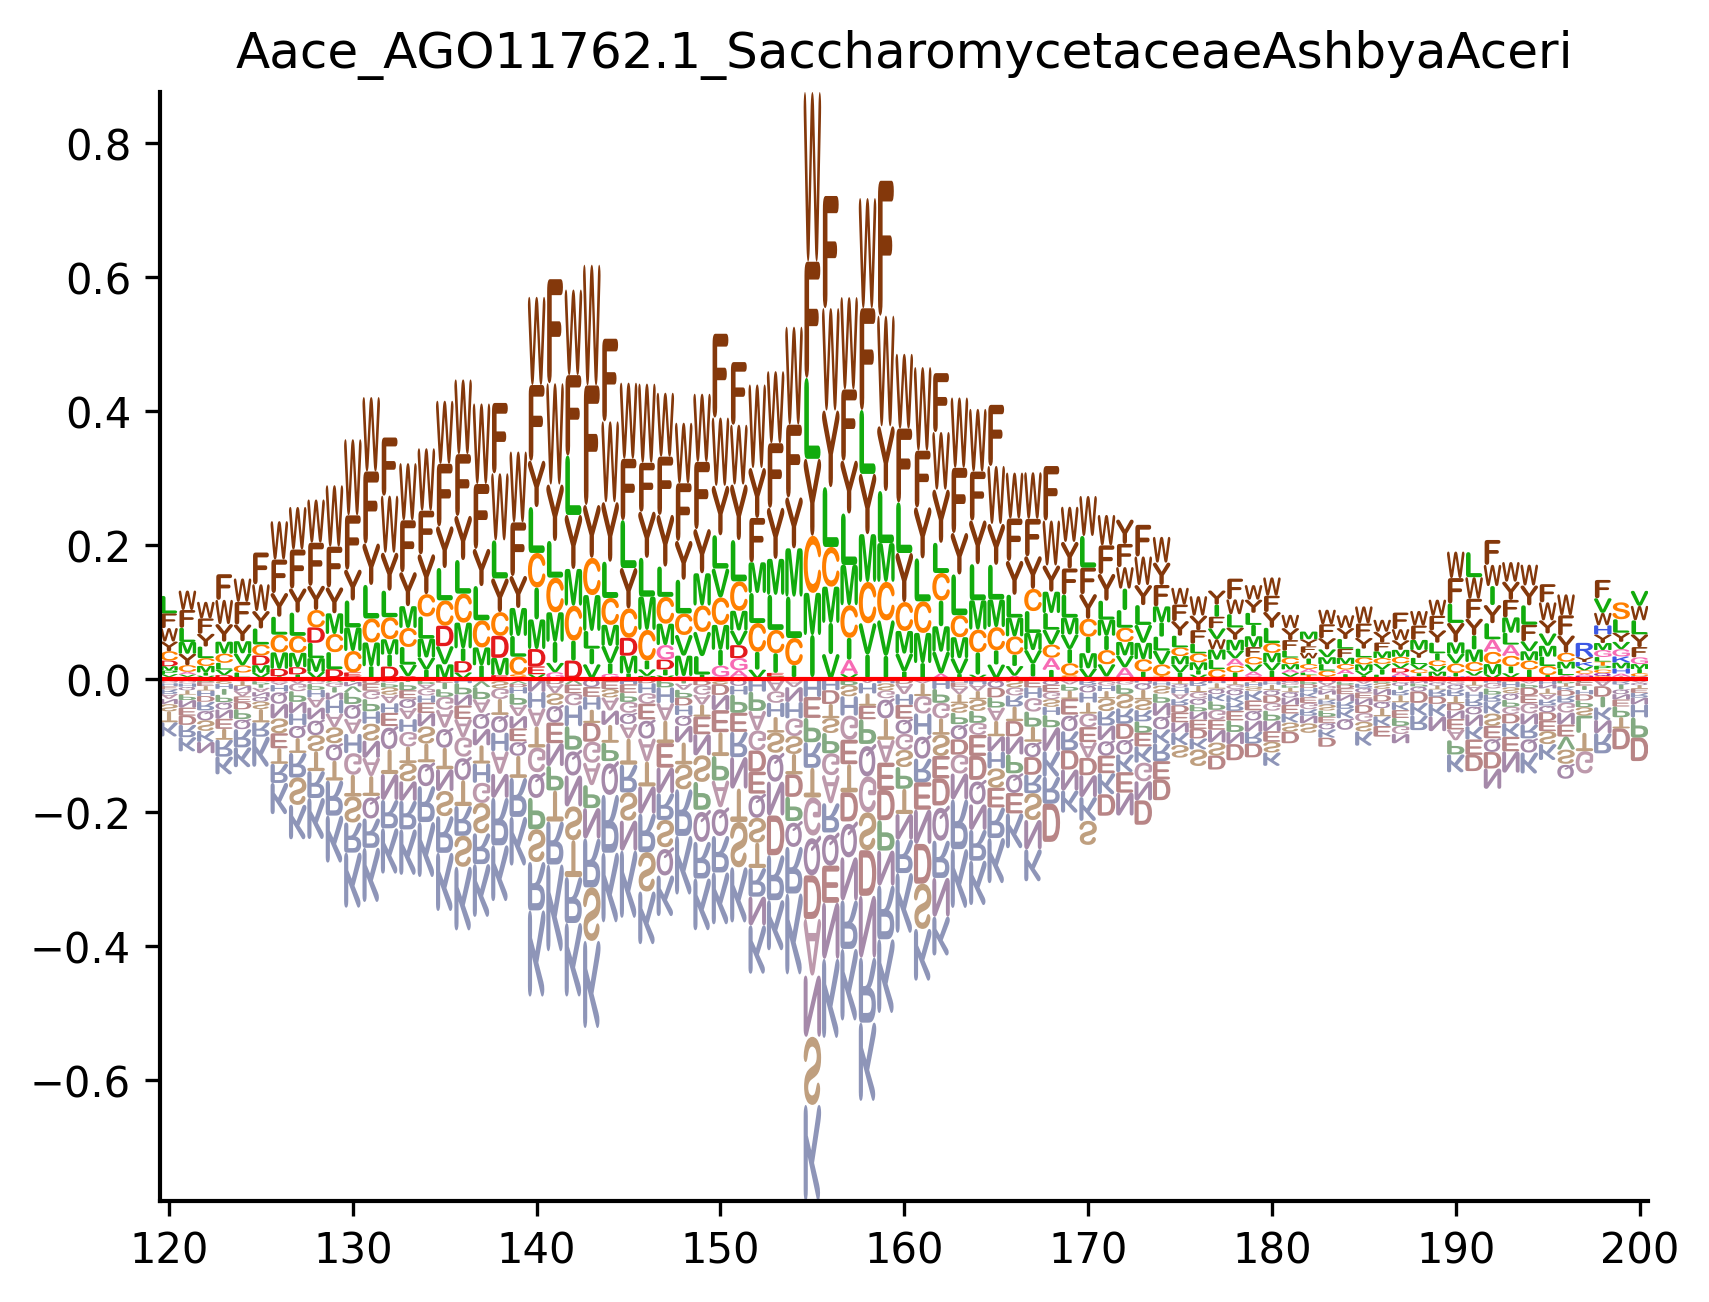

In [70]:
fig, ax = plt.subplots(dpi=300)
crp_logo = logomaker.Logo(M_bar.T.loc[120:200],
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                          color_scheme="dmslogo_funcgroup",
                          ax=ax)
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.ax.axhline(0, c='r', linewidth=1)
crp_logo.ax.set_title(df0["SpeciesNames"].unique().item())
plt.show()

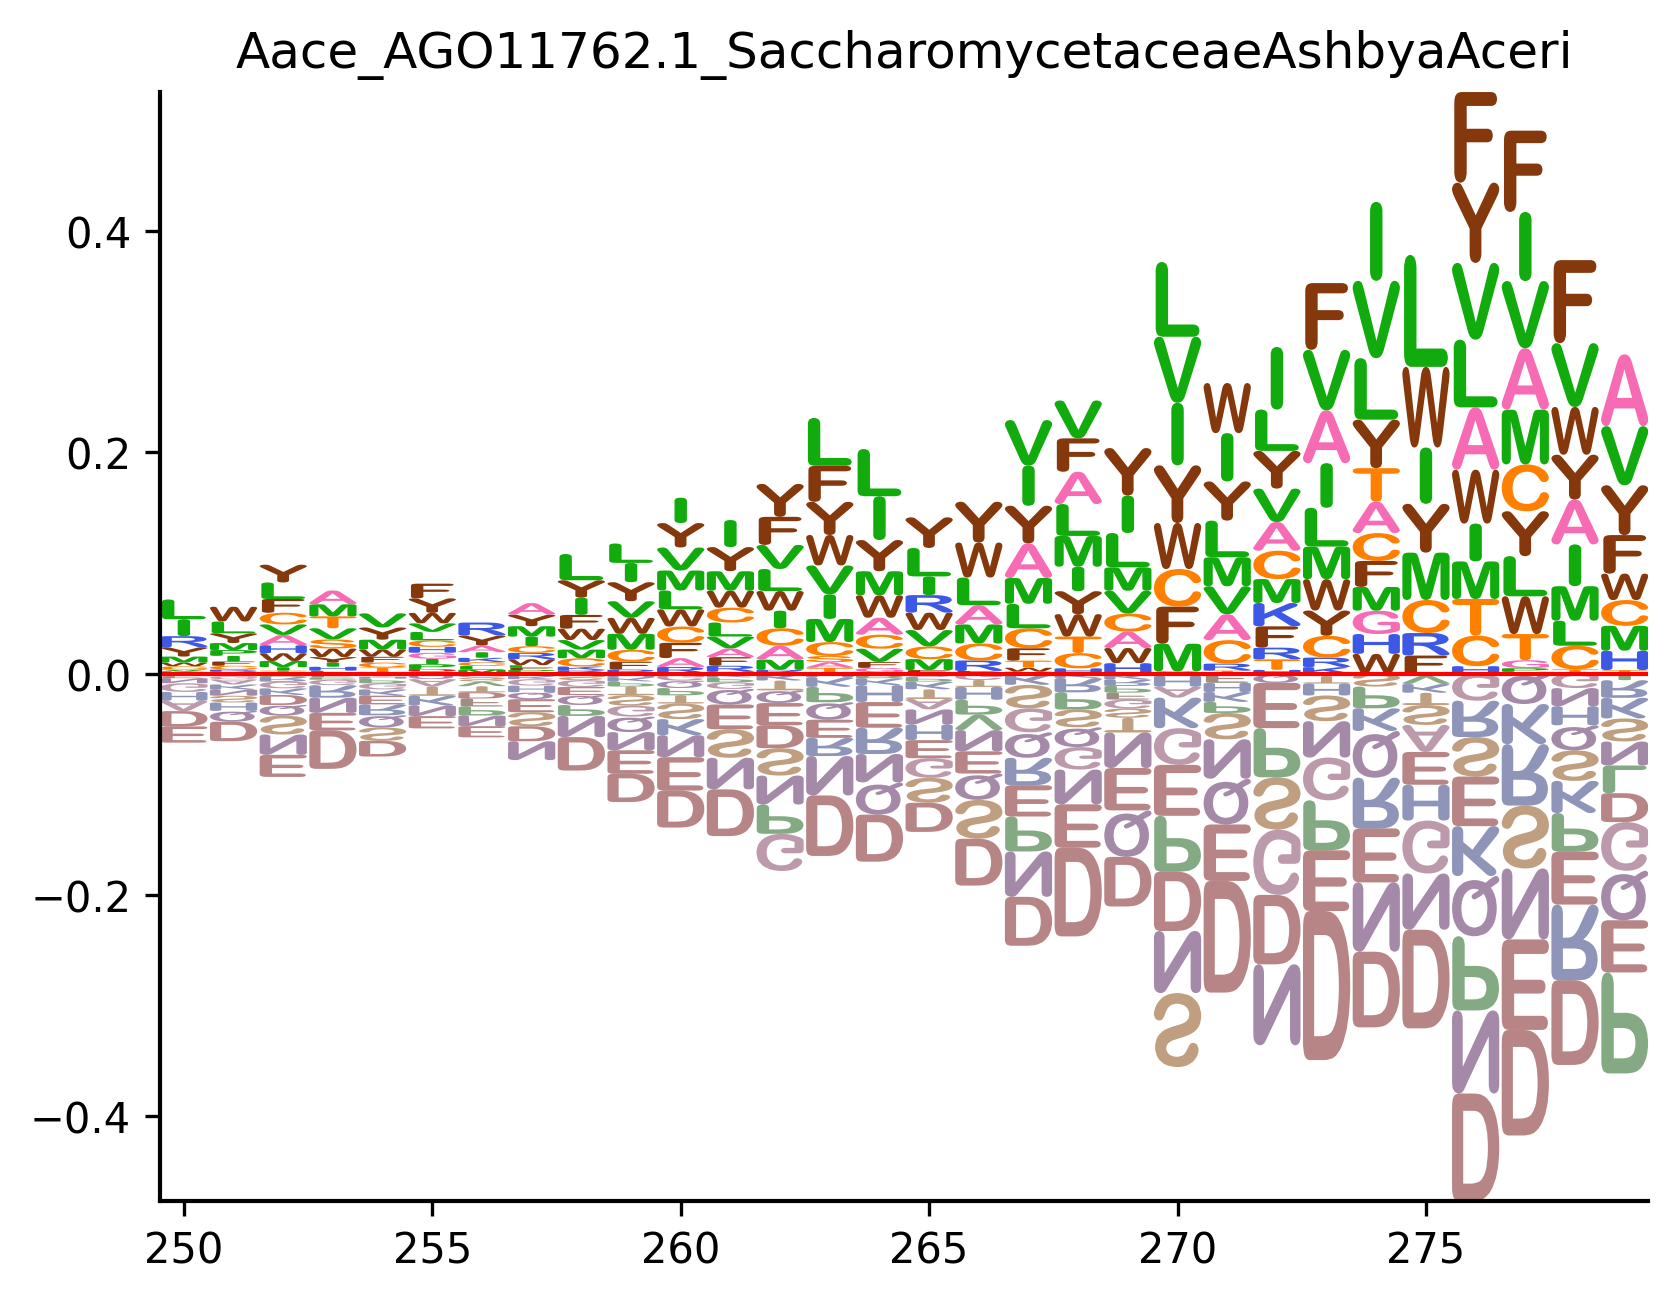

In [74]:
fig, ax = plt.subplots(dpi=300)
crp_logo = logomaker.Logo(M_bar.T.loc[250:280],
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                          color_scheme="dmslogo_funcgroup",
                          ax=ax)
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.ax.axhline(0, c='r', linewidth=1)
crp_logo.ax.set_title(df0["SpeciesNames"].unique().item())
plt.show()

'ASYNPVVSNNASASEVRGVPAPEDDFDDAMNLKMGLHGPK'

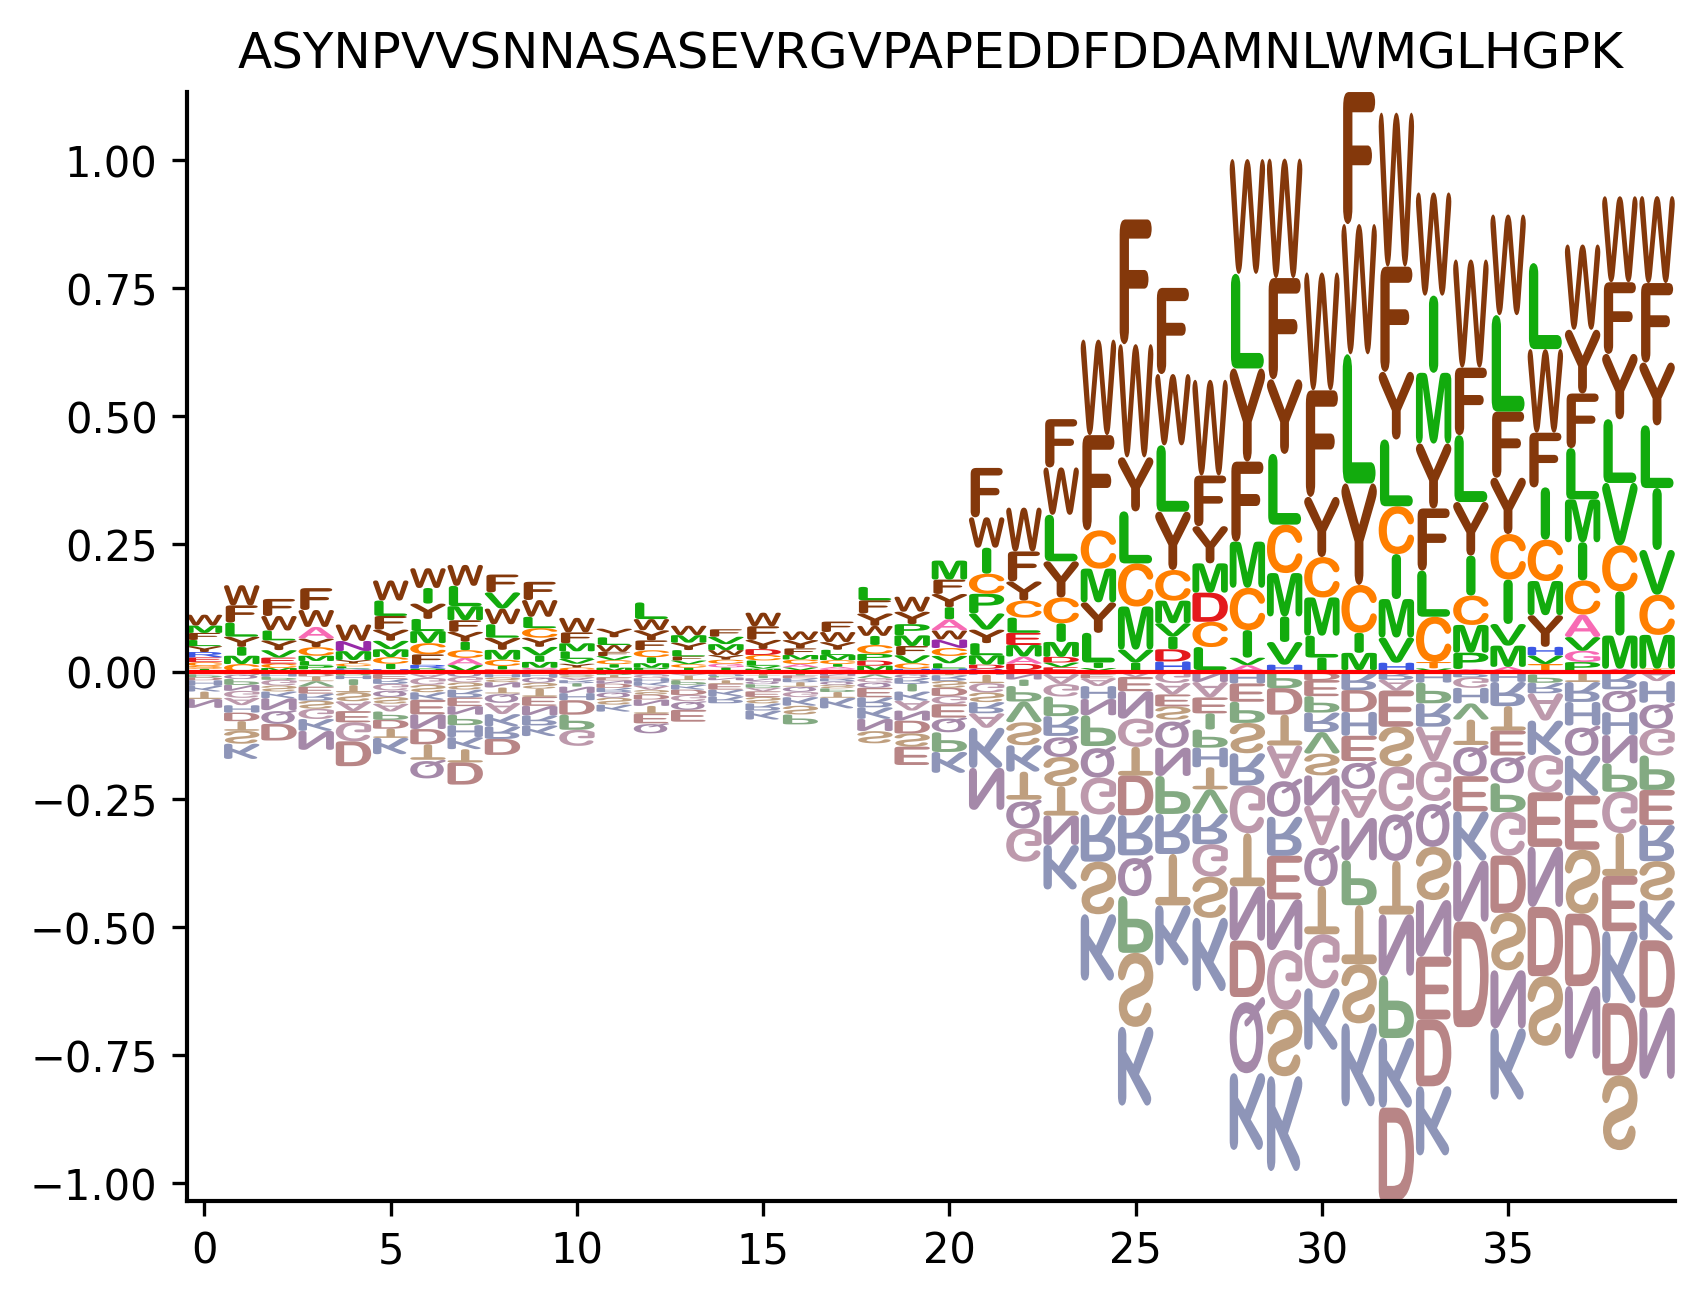

In [86]:
dl = LayerDeepLift(model, layer=model.model.emb, multiply_by_inputs=False,)

strongAD_scores = get_attr(dl, strongAD, baseline_gs)
# strongAD_scores_noW = get_attr(dl, encode(strong.replace("W", "K")), baseline_gs)
fig, ax = plt.subplots(dpi=300)
crp_logo = logomaker.Logo((strongAD_scores).T,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                          color_scheme="dmslogo_funcgroup",
                          ax=ax)
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.ax.axhline(0, c='r', linewidth=1)
crp_logo.ax.set_title(strong)
plt.show()

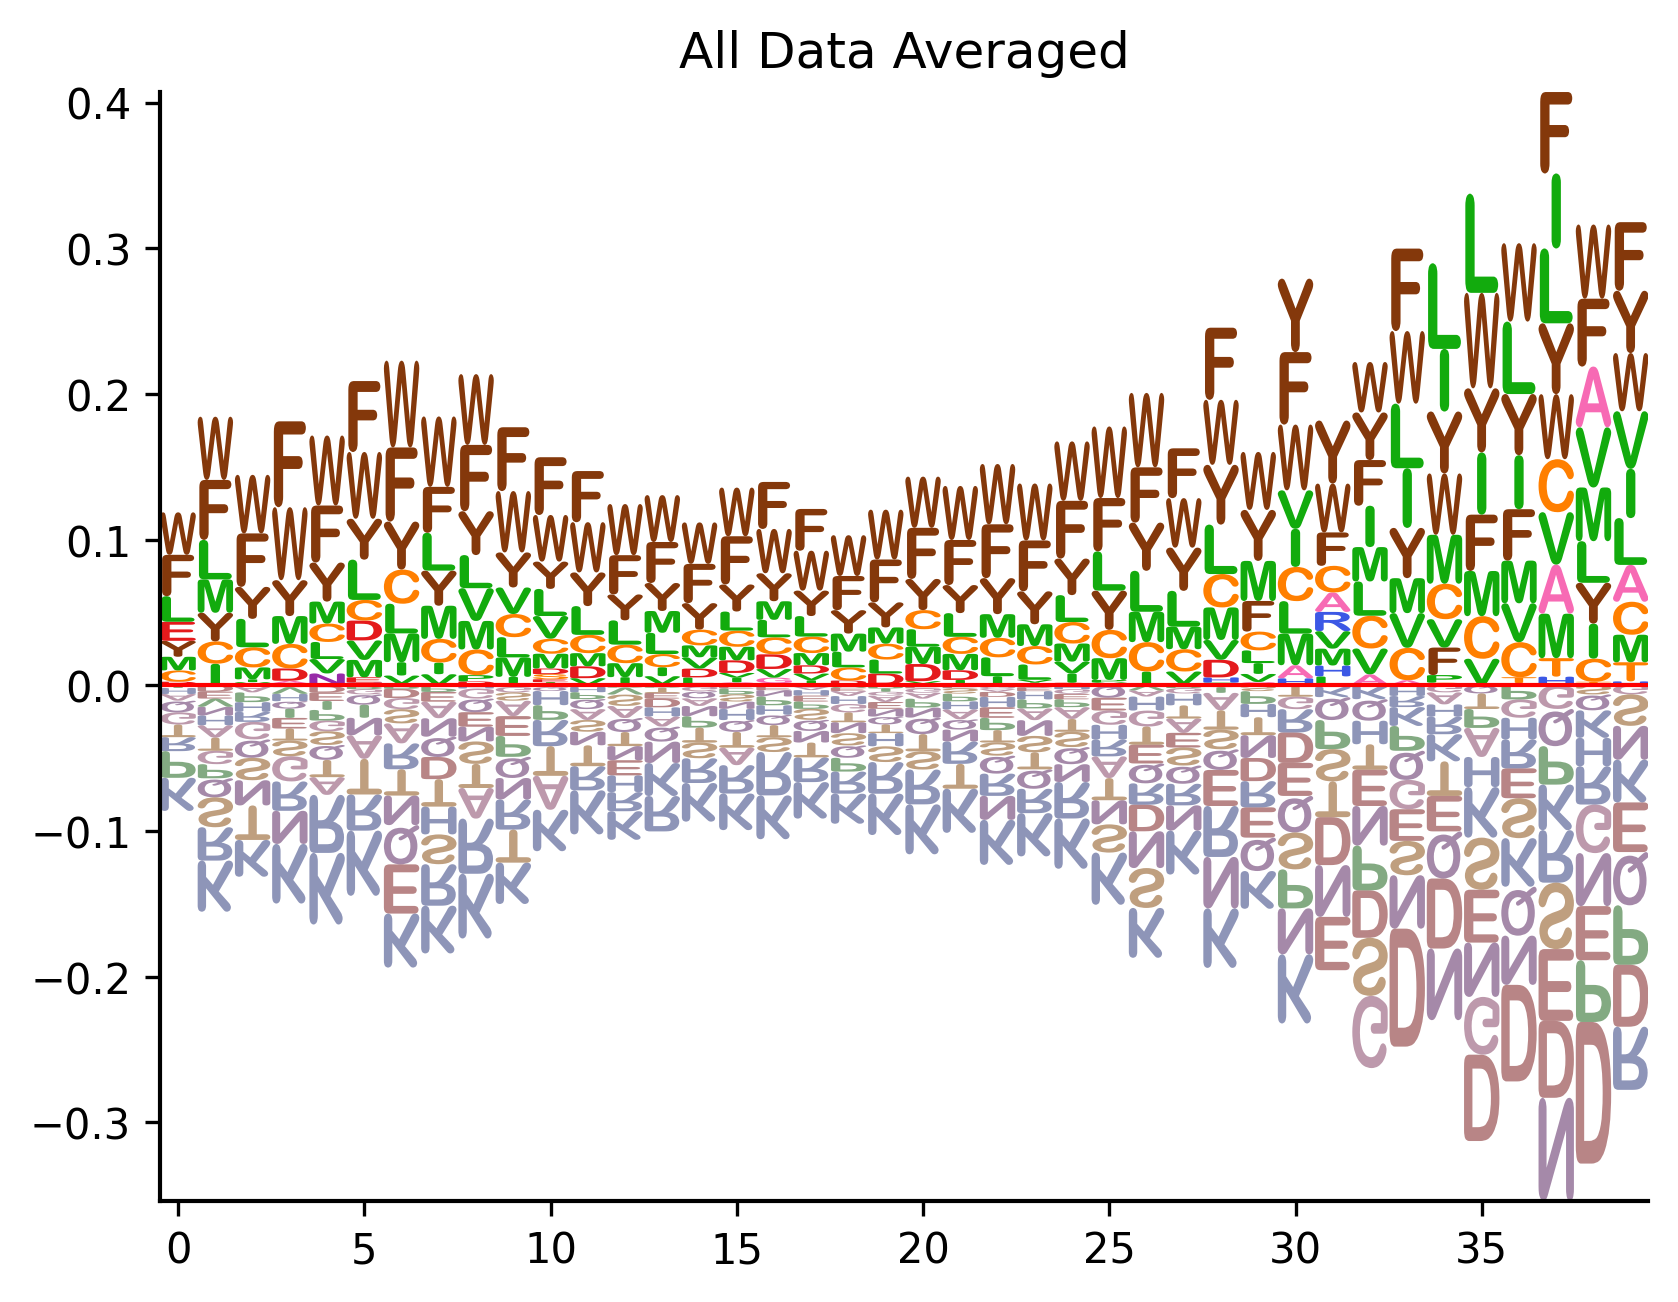

In [95]:
X_score_df = pd.DataFrame(x_scores.mean(axis=0))
X_score_df.columns = list(alphabet)

fig, ax = plt.subplots(dpi=300)
crp_logo = logomaker.Logo(X_score_df,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                          color_scheme="dmslogo_funcgroup",
                          ax=ax)
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.ax.axhline(0, c='r', linewidth=1)
crp_logo.ax.set_title("All Data Averaged")
plt.show()

In [116]:
ad_threshold = 80_000
X_ad = torch.tensor(X[np.where(df["Activity"] >= ad_threshold)[0]])
att_ad_df_weakad = get_attr(dl, X_ad, baseline=weakAD)

# Input-wise averages for activation domains
dl_inputwise = LayerDeepLift(model, layer=model.model.emb, multiply_by_inputs=True,)
att_ad_df_weakad_inputwise = get_attr(dl_inputwise, X_ad, baseline=weakAD)


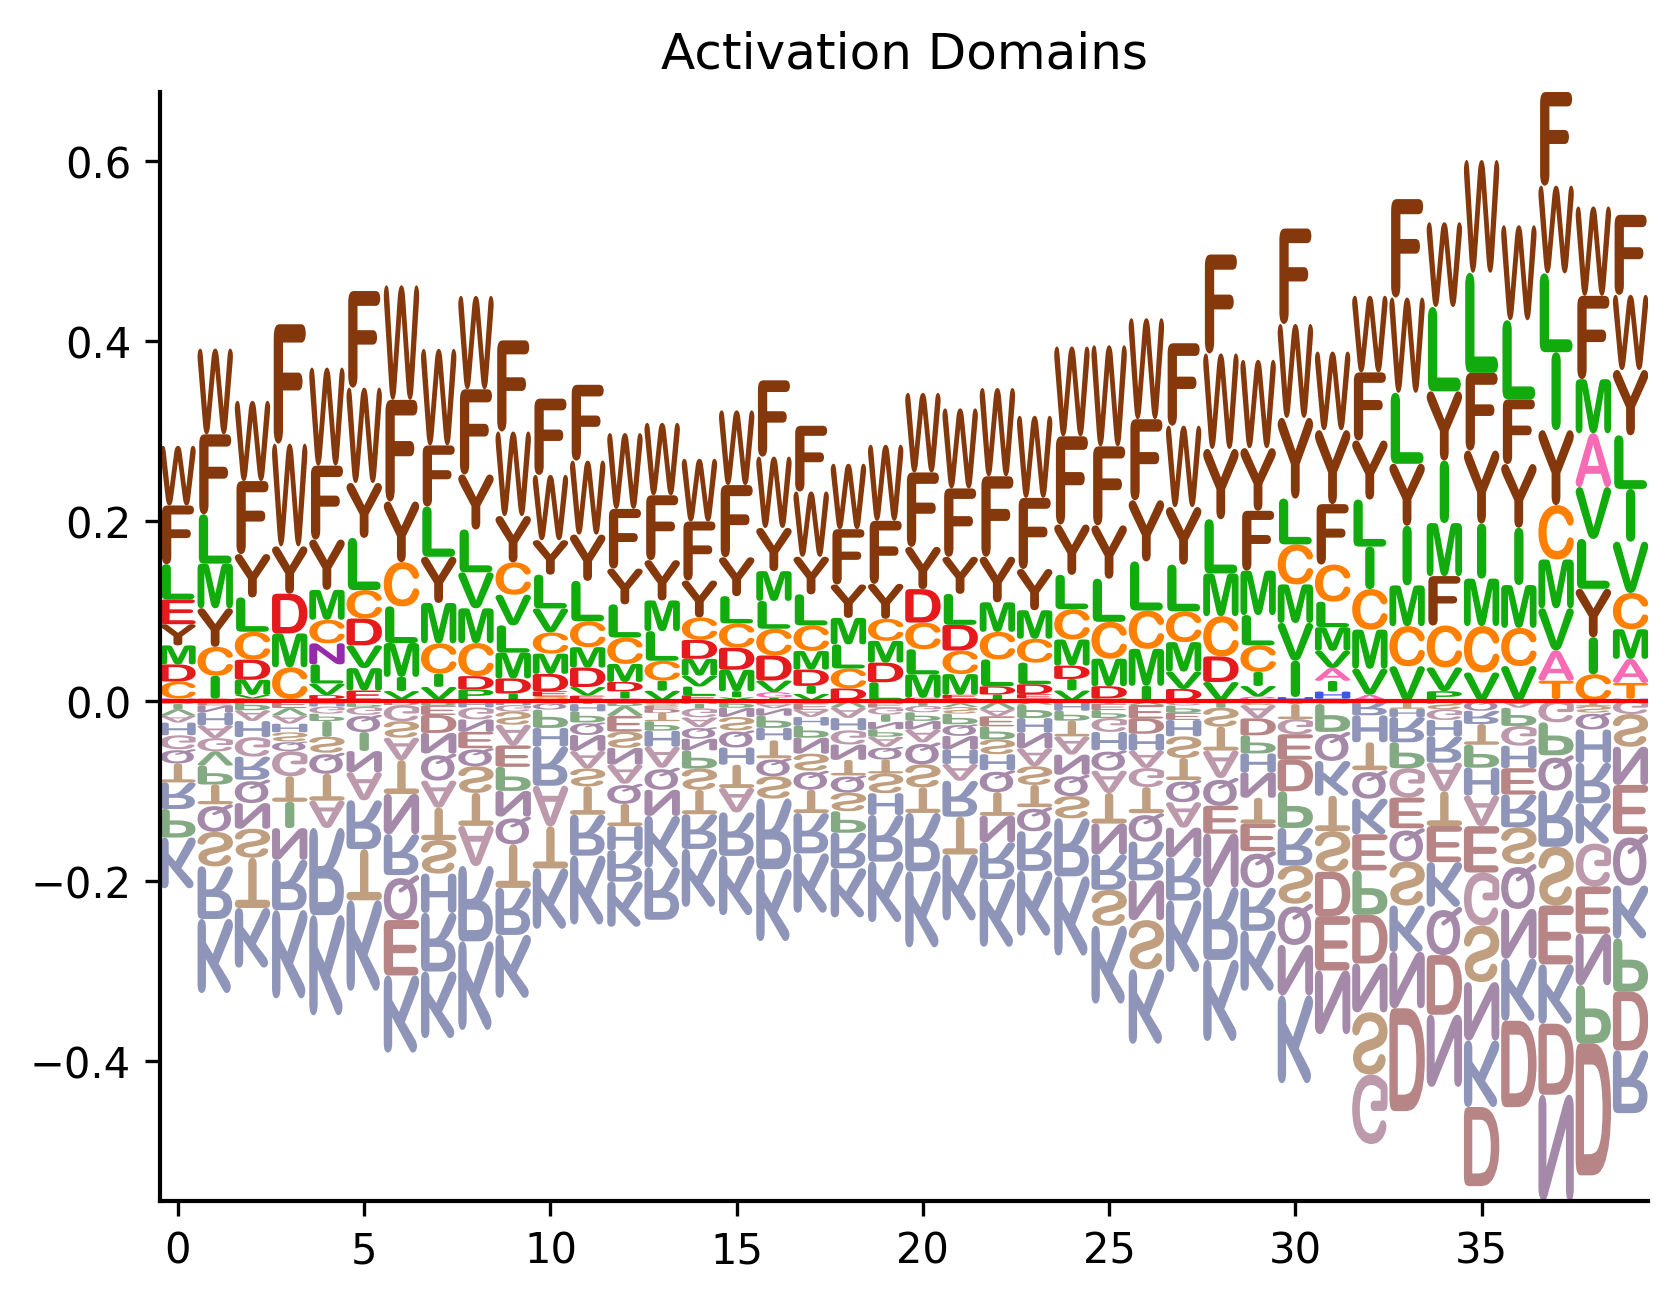

In [119]:
fig, ax = plt.subplots(dpi=300)
crp_logo = logomaker.Logo(att_ad_df_weakad.T,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                          color_scheme="dmslogo_funcgroup",
                          ax=ax)
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.ax.axhline(0, c='r', linewidth=1)
crp_logo.ax.set_title("Activation Domains")
plt.show()
# fig, ax = plt.subplots(dpi=300)
# crp_logo = logomaker.Logo(att_ad_df_weakad_inputwise.T,
#                           shade_below=.5,
#                           fade_below=.5,
#                           font_name='Arial Rounded MT Bold',
#                           color_scheme="dmslogo_funcgroup",
#                           ax=ax)
# crp_logo.style_spines(visible=False)
# crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
# crp_logo.ax.axhline(0, c='r', linewidth=1)
# crp_logo.ax.set_title("Activation Domains (multiply by inputs)")
# plt.show()